## Seasonal means all in one

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Mythical code button"></form>''')

In [3]:
import scipy
import netCDF4 as nc
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import cmocean as cm
import pipvis as vp
from importlib import reload
import xarray as xr

import sys
sys.path.append('./extraction_scripts')
import map_fxn as mf
reload(vp)


<module 'pipvis' from '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pipvis.py'>

In [4]:
def add_subplot_border(ax, width=1, color=None ):

    fig = ax.get_figure()

    # Convert bottom-left and top-right to display coordinates
    x0, y0 = ax.transAxes.transform((0, 0))
    x1, y1 = ax.transAxes.transform((1, 1))

    # Convert back to Axes coordinates
    x0, y0 = ax.transAxes.inverted().transform((x0, y0))
    x1, y1 = ax.transAxes.inverted().transform((x1, y1))

    rect = plt.Rectangle(
        (x0, y0), x1-x0, y1-y0,
        color=color,
        transform=ax.transAxes,
        zorder=-1,
        lw=2*width+1,
        fill=None,
    )
    fig.patches.append(rect)


In [5]:
colors = ['white',
          'goldenrod',
          'dimgray',
          'skyblue',
          'red',
          'midnightblue',
          'deepskyblue','gray','peru',
'olive','sandybrown','teal','pink','tan',
'yellow','thistle']

## chceck that reassigning worked

In [6]:
cl_bio_2013 = pickle.load(open('./pkls/bio_clustmat_2013.pkl', 'rb'))
cl_bio_2014 = pickle.load(open('./pkls/bio_clustmat_2014.pkl', 'rb'))
cl_bio_2015 = pickle.load(open('./pkls/bio_clustmat_2015.pkl', 'rb'))
cl_bio_2016 = pickle.load(open('./pkls/bio_clustmat_2016.pkl', 'rb'))
sig_bio_2013 = pickle.load(open('./pkls/bio_datamat_2013.pkl', 'rb'))
sig_bio_2014 = pickle.load(open('./pkls/bio_datamat_2014.pkl', 'rb'))
sig_bio_2015 = pickle.load(open('./pkls/bio_datamat_2015.pkl', 'rb'))
sig_bio_2016 = pickle.load(open('./pkls/bio_datamat_2016.pkl', 'rb'))
cldes_2013_reass_bio = pickle.load(open('./pkls/bio_clno_5_2013_reass.pkl', 'rb'))
cldes_2014_reass_bio = pickle.load(open('./pkls/bio_clno_5_2014_reass.pkl', 'rb'))
cldes_2015_reass_bio = pickle.load(open('./pkls/bio_clno_5_2015_reass.pkl', 'rb'))
cldes_2016_reass_bio = pickle.load(open('./pkls/bio_clno_5_2016_reass.pkl', 'rb'))

In [7]:
print(np.shape(sig_bio_2013))
print(1095/365)

(571, 1095)
3.0


In [8]:
def rowbuilder(sigmats,clustmats, ylab, tylim, fs, ax1,ax2,ax3,ax4,ax5, verbose = False):
    spr_st = 59; spr_e = 151; sum_st = 151; sum_e = 243;
    aut_st = 243; aut_e = 334;
    spac = 0.08

    #5 saesons (incl full year), 4 years, 5 clusters, 2 quantities (mean or sd)
    saver = np.zeros([5,4,5,2])
    yrs = [2013,2014,2015,2016]; clustnos = [5,5,5,5]
    nodays =  [365,365,365,366]; clustdes = [1,2,3,4,5]; 

    for i in range(0,4):
        yr = yrs[i]; noday = nodays[i]
        tclmat = clustmats[i]; clustno = clustnos[i]; sigmat = sigmats[i]; noday = nodays[i]
        for c in range(0,len(clustdes)):
            tmean = (vp.cluster_patterns_mean(sigmat,tclmat,clustdes[c],noday))
            yrmean = np.nanmean(tmean); yrstd = np.nanstd(tmean)
            ax1.errorbar(yr+(c*spac), yrmean, yerr=yrstd, color=colors[c+1], fmt='o')
            saver[0,i,c,0] = yrmean; saver[0,i,c,1] = yrstd; 

    ax1.set_xlim([2012.5,2016.5]); ax1.set_ylim([0,tylim])
    ax1.yaxis.grid(True)
    ax1.set_xticks([2013,2014,2015,2016])
    ax1.set_xticklabels([2013,2014,2015,2016], fontsize = fs)
    ax1.set_ylabel(ylab)
    ax1.set_title('FULL YEAR', fontsize = fs)
    add_subplot_border(ax1, width=2, color='black' )

    for i in range(0,4):
        yr = yrs[i]; noday = nodays[i]
        tclmat = clustmats[i]; clustno = clustnos[i]; sigmat = sigmats[i]; noday = nodays[i]
        for c in range(0,len(clustdes)):
            tmean = (vp.cluster_patterns_mean(sigmat,tclmat,clustdes[c],noday))
            yrmean = np.nanmean(tmean[spr_st:spr_e]); yrstd = np.nanstd(tmean[spr_st:spr_e])
            ax2.errorbar(yr+(c*spac), yrmean, yerr=yrstd, color=colors[c+1], fmt='o')
            saver[1,i,c,0] = yrmean; saver[1,i,c,1] = yrstd; 
            
    ax2.yaxis.grid(True)
    ax2.set_xlim([2012.5,2016.5]); ax2.set_ylim([0,tylim])
    ax2.set_yticklabels([])
    ax2.set_xticks([2013,2014,2015,2016])
    ax2.set_xticklabels([2013,2014,2015,2016], fontsize = fs)
    ax2.set_title('SPRING', fontsize = fs)

    for i in range(0,4):
        yr = yrs[i]; noday = nodays[i]
        tclmat = clustmats[i]; clustno = clustnos[i]; sigmat = sigmats[i]; noday = nodays[i]
        for c in range(0,len(clustdes)):
            tmean = (vp.cluster_patterns_mean(sigmat,tclmat,clustdes[c],noday))
            yrmean = np.nanmean(tmean[sum_st:sum_e]); yrstd = np.nanstd(tmean[sum_st:sum_e])
            ax3.errorbar(yr+(c*spac), yrmean, yerr=yrstd, color=colors[c+1], fmt='o')
            saver[2,i,c,0] = yrmean; saver[2,i,c,1] = yrstd;  
            
    ax3.yaxis.grid(True)
    ax3.set_xlim([2012.5,2016.5]); ax3.set_ylim([0,tylim])
    ax3.set_yticklabels([])
    ax3.set_xticks([2013,2014,2015,2016])
    ax3.set_xticklabels([2013,2014,2015,2016], fontsize = fs)
    ax3.set_title('SUMMER', fontsize = fs)

    for i in range(0,4):
        yr = yrs[i]; noday = nodays[i]
        tclmat = clustmats[i]; clustno = clustnos[i]; sigmat = sigmats[i]; noday = nodays[i]
        for c in range(0,len(clustdes)):
            tmean = (vp.cluster_patterns_mean(sigmat,tclmat,clustdes[c],noday))
            yrmean = np.nanmean(tmean[aut_st:aut_e]); yrstd = np.nanstd(tmean[aut_st:aut_e])
            ax4.errorbar(yr+(c*spac), yrmean, yerr=yrstd, color=colors[c+1], fmt='o')
            saver[3,i,c,0] = yrmean; saver[3,i,c,1] = yrstd; 
            
    ax4.yaxis.grid(True)
    ax4.set_xlim([2012.5,2016.5]); ax4.set_ylim([0,tylim])
    ax4.set_yticklabels([])
    ax4.set_xticks([2013,2014,2015,2016])
    ax4.set_xticklabels([2013,2014,2015,2016], fontsize = fs)
    ax4.set_title('AUTUMN', fontsize = fs)

    for i in range(0,4):
        yr = yrs[i]; noday = nodays[i]
        tclmat = clustmats[i]; clustno = clustnos[i]; sigmat = sigmats[i]; noday = nodays[i]
        for c in range(0,len(clustdes)):
            tmean = (vp.cluster_patterns_mean(sigmat,tclmat,clustdes[c],noday))
            wintmean = np.concatenate((tmean[0:spr_st],tmean[aut_e:(np.size(tmean)-1)]),axis = 0)
            yrmean = np.nanmean(wintmean); yrstd = np.nanstd(wintmean)
            ax5.errorbar(yr+(c*spac), yrmean, yerr=yrstd, color=colors[c+1], fmt='o')
            saver[4,i,c,0] = yrmean; saver[4,i,c,1] = yrstd; 
#             print(saver[4,i,c,1] )
#             print(saver[4,i,c,1] )
            
    ax5.yaxis.grid(True)
    ax5.set_xlim([2012.5,2016.5]); ax5.set_ylim([0,tylim])
    ax5.set_yticklabels([])
    ax5.set_xticks([2013,2014,2015,2016])
    ax5.set_xticklabels([2013,2014,2015,2016], fontsize = fs)
    ax5.set_title('WINTER', fontsize = fs)
    
    return saver

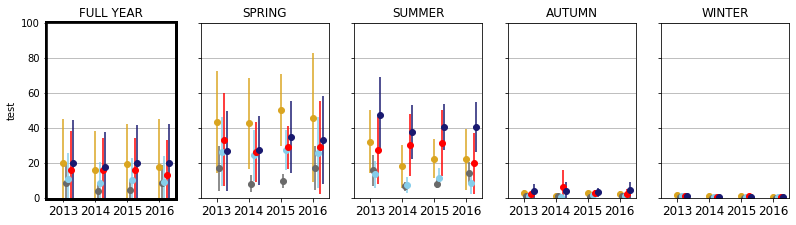

In [10]:
tylim = 100
fact = 0.7

fs = 12

#(sigmats,clustmats, ylab, tylim, fs, ax1,ax2,ax3,ax4,ax5):
#season definitions
#spring march 1 to may 31
fig = plt.figure(figsize=(19*fact, 4.6*fact))

ax1 = plt.subplot2grid((1,5), (0,0), colspan=1, rowspan=1) 
ax2 = plt.subplot2grid((1,5), (0,1), colspan=1, rowspan=1) 
ax3 = plt.subplot2grid((1,5), (0,2), colspan=1, rowspan=1) 
ax4 = plt.subplot2grid((1,5), (0,3), colspan=1, rowspan=1) 
ax5 = plt.subplot2grid((1,5), (0,4), colspan=1, rowspan=1) 

sigmats = [sig_bio_2013[:,0:365],sig_bio_2014[:,0:365],sig_bio_2015[:,0:365],sig_bio_2016[:,0:366]]
clustmats = [cldes_2013_reass_bio,cldes_2014_reass_bio,\
             cldes_2015_reass_bio,cldes_2016_reass_bio]
#ylab = 'mean freshwater index \n [g kg$^{-1}$ m$^{-1}$]'

ylab = 'test'
testsaver_diat = rowbuilder(sigmats,clustmats, ylab, tylim, fs, ax1,ax2,ax3,ax4,ax5)



In [11]:
sig_diat_2013 = np.squeeze(sig_bio_2013[:,0:365]),
sig_diat_2014 = np.squeeze(sig_bio_2014[:,0:365]),
sig_diat_2015 = np.squeeze(sig_bio_2015[:,0:365]),
sig_diat_2016 = np.squeeze(sig_bio_2016[:,0:366]),

sig_flag_2013 = np.squeeze(sig_bio_2013[:,365:365*2]),
sig_flag_2014 = np.squeeze(sig_bio_2014[:,365:365*2]),
sig_flag_2015 = np.squeeze(sig_bio_2015[:,365:365*2]),
sig_flag_2016 = np.squeeze(sig_bio_2016[:,366:366*2]),

sig_cili_2013 = np.squeeze(sig_bio_2013[:,365*2:365*3]),
sig_cili_2014 = np.squeeze(sig_bio_2014[:,365*2:365*3]),
sig_cili_2015 = np.squeeze(sig_bio_2015[:,365*2:365*3]),
sig_cili_2016 = np.squeeze(sig_bio_2016[:,366*2:366*3]),



sig_cili_2013 = np.squeeze(sig_cili_2013)
sig_cili_2014 = np.squeeze(sig_cili_2014)
sig_cili_2015 = np.squeeze(sig_cili_2015)
sig_cili_2016 = np.squeeze(sig_cili_2016)

sig_flag_2013 = np.squeeze(sig_flag_2013)
sig_flag_2014 = np.squeeze(sig_flag_2014)
sig_flag_2015 = np.squeeze(sig_flag_2015)
sig_flag_2016 = np.squeeze(sig_flag_2016)

sig_diat_2013 = np.squeeze(sig_diat_2013)
sig_diat_2014 = np.squeeze(sig_diat_2014)
sig_diat_2015 = np.squeeze(sig_diat_2015)
sig_diat_2016 = np.squeeze(sig_diat_2016)

sig_bmtot_2013 = sig_diat_2013 + sig_flag_2013 + sig_cili_2013
sig_bmtot_2014 = sig_diat_2014 + sig_flag_2014 + sig_cili_2014
sig_bmtot_2015 = sig_diat_2015 + sig_flag_2015 + sig_cili_2015
sig_bmtot_2016 = sig_diat_2016 + sig_flag_2016 + sig_cili_2016


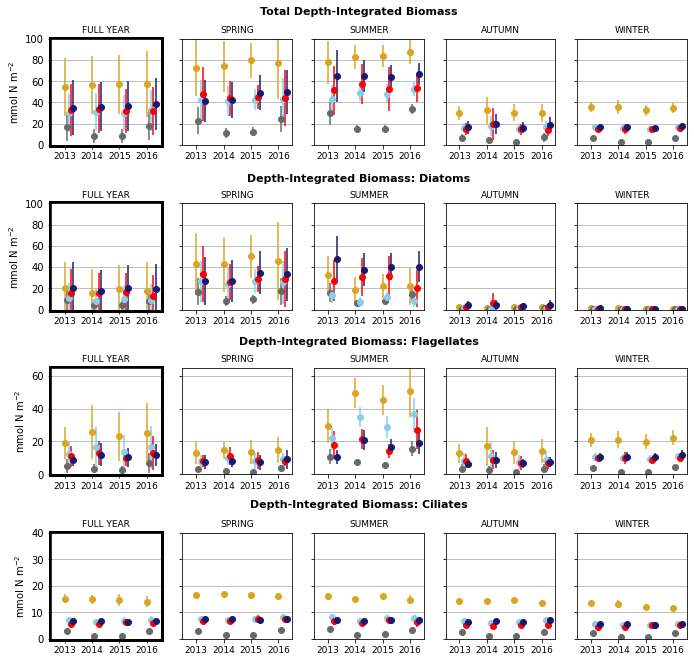

In [12]:
fact = 0.7
fact = 0.6
fs = 9

fig, axs = plt.subplots(4,5, figsize=(19*fact, 4.6*4*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
plt.subplots_adjust(hspace=0.55)
fig.text(0.5, 0.91, 'Total Depth-Integrated Biomass', fontsize = fs+2, fontweight = 'bold', ha = 'center')

sigmats = [sig_bmtot_2013,sig_bmtot_2014,sig_bmtot_2015,sig_bmtot_2016]
clustmats = [cldes_2013_reass_bio,cldes_2014_reass_bio,\
             cldes_2015_reass_bio,cldes_2016_reass_bio]
ylab = 'mmol N m$^{-2}$'
saver_bmtot = rowbuilder(sigmats,clustmats, ylab, 100, fs, axs[0],axs[1],axs[2],axs[3],axs[4])

fig.text(0.5, 0.70, 'Depth-Integrated Biomass: Diatoms', fontsize = fs+2, fontweight = 'bold', ha = 'center')

sigmats = [sig_diat_2013,sig_diat_2014,sig_diat_2015,sig_diat_2016]
clustmats = [cldes_2013_reass_bio,cldes_2014_reass_bio,\
             cldes_2015_reass_bio,cldes_2016_reass_bio]
ylab = 'mmol N m$^{-2}$'
saver_diat = rowbuilder(sigmats,clustmats, ylab, 100, fs, axs[5],axs[6],axs[7],axs[8],axs[9])

fig.text(0.5, 0.69-0.21+0.015, 'Depth-Integrated Biomass: Flagellates', fontsize = fs+2, fontweight = 'bold', ha = 'center')
sigmats = [sig_flag_2013,sig_flag_2014,sig_flag_2015,sig_flag_2016]
clustmats = [cldes_2013_reass_bio,cldes_2014_reass_bio,\
             cldes_2015_reass_bio,cldes_2016_reass_bio]
ylab = 'mmol N m$^{-2}$'
saver_flag = rowbuilder(sigmats,clustmats, ylab, 65, fs, axs[10],axs[11],axs[12],axs[13],axs[14])

fig.text(0.5, 0.69-0.21*2+0.02, 'Depth-Integrated Biomass: Ciliates', fontsize = fs+2, fontweight = 'bold', ha = 'center')
sigmats = [sig_cili_2013,sig_cili_2014,sig_cili_2015,sig_cili_2016]
clustmats = [cldes_2013_reass_bio,cldes_2014_reass_bio,\
             cldes_2015_reass_bio,cldes_2016_reass_bio]
ylab = 'mmol N m$^{-2}$'
saver_cili = rowbuilder(sigmats,clustmats, ylab, 40, fs, axs[15],axs[16],axs[17],axs[18],axs[19])

#fig.savefig('./paper_figs/MF04-seasmeans.jpg', bbox_inches='tight', dpi = 300)
#plt.text('Row2', fontsize = fs+3, y = 0.65)

In [13]:

xr_bmtot = xr.DataArray(
    saver_bmtot,
    [
        ("season", ["FullYear", "Spring", "Summer", "Autumn","Winter"]),
        ("year", [2013,2014,2015,2016]),
        ("CLID", ['tidal mixing/gold','nearshore/grey',\
                     'central Strait/skyblue','northern Strait/red','JdF/ darkblue']),
        ("metric", ["mean mmolN/m2", "std. dev mmolN/m2"]),
    ],
)

xr_diat = xr.DataArray(
    saver_diat,
    [
        ("season", ["FullYear", "Spring", "Summer", "Autumn","Winter"]),
        ("year", [2013,2014,2015,2016]),
        ("CLID", ['tidal mixing/gold','nearshore/grey',\
                     'central Strait/skyblue','northern Strait/red','JdF/ darkblue']),
        ("metric", ["mean mmolN/m2", "std. dev mmolN/m2"]),
    ],
)
xr_flag = xr.DataArray(
    saver_flag,
    [
        ("season", ["FullYear", "Spring", "Summer", "Autumn","Winter"]),
        ("year", [2013,2014,2015,2016]),
        ("CLID", ['tidal mixing/gold','nearshore/grey',\
                     'central Strait/skyblue','northern Strait/red','JdF/ darkblue']),
        ("metric", ["mean mmolN/m2", "std. dev mmolN/m2"]),
    ],
)
print(np.shape(saver_bmtot))




(5, 4, 5, 2)


In [14]:
print('For years 2013-2016, spring total biomass in central and northern strait')
print('')
print(xr_bmtot.loc["Spring",2013,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_bmtot.loc["Spring",2014,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_bmtot.loc["Spring",2015,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_bmtot.loc["Spring",2016,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])

print('')
print('For years 2013-2016, summer total biomass in central and northern strait')

print(xr_bmtot.loc["Summer",2013,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_bmtot.loc["Summer",2014,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_bmtot.loc["Summer",2015,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_bmtot.loc["Summer",2016,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])


For years 2013-2016, spring total biomass in central and northern strait

<xarray.DataArray (CLID: 2)>
array([41.83548016, 47.85174687])
Coordinates:
    season   <U8 'Spring'
    year     int64 2013
  * CLID     (CLID) <U22 'central Strait/skyblue' 'northern Strait/red'
    metric   <U17 'mean mmolN/m2'

<xarray.DataArray (CLID: 2)>
array([41.33665101, 43.80271185])
Coordinates:
    season   <U8 'Spring'
    year     int64 2014
  * CLID     (CLID) <U22 'central Strait/skyblue' 'northern Strait/red'
    metric   <U17 'mean mmolN/m2'

<xarray.DataArray (CLID: 2)>
array([42.69384808, 44.83500262])
Coordinates:
    season   <U8 'Spring'
    year     int64 2015
  * CLID     (CLID) <U22 'central Strait/skyblue' 'northern Strait/red'
    metric   <U17 'mean mmolN/m2'

<xarray.DataArray (CLID: 2)>
array([43.00777845, 44.21073387])
Coordinates:
    season   <U8 'Spring'
    year     int64 2016
  * CLID     (CLID) <U22 'central Strait/skyblue' 'northern Strait/red'
    metric   <U17 'mean mmolN

In [15]:
print('For years 2013-2016, spring diatom biomass in central and northern strait')
print('')
print(xr_diat.loc["Spring",2013,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_diat.loc["Spring",2014,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_diat.loc["Spring",2015,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_diat.loc["Spring",2016,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])

print('')
print('For years 2013-2016, summer diatom biomass in central and northern strait')

print(xr_diat.loc["Summer",2013,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_diat.loc["Summer",2014,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_diat.loc["Summer",2015,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_diat.loc["Summer",2016,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])


For years 2013-2016, spring diatom biomass in central and northern strait

<xarray.DataArray (CLID: 2)>
array([26.4063436 , 33.30423384])
Coordinates:
    season   <U8 'Spring'
    year     int64 2013
  * CLID     (CLID) <U22 'central Strait/skyblue' 'northern Strait/red'
    metric   <U17 'mean mmolN/m2'

<xarray.DataArray (CLID: 2)>
array([24.34309099, 26.10291256])
Coordinates:
    season   <U8 'Spring'
    year     int64 2014
  * CLID     (CLID) <U22 'central Strait/skyblue' 'northern Strait/red'
    metric   <U17 'mean mmolN/m2'

<xarray.DataArray (CLID: 2)>
array([27.22350472, 28.85907135])
Coordinates:
    season   <U8 'Spring'
    year     int64 2015
  * CLID     (CLID) <U22 'central Strait/skyblue' 'northern Strait/red'
    metric   <U17 'mean mmolN/m2'

<xarray.DataArray (CLID: 2)>
array([25.81823331, 28.88680481])
Coordinates:
    season   <U8 'Spring'
    year     int64 2016
  * CLID     (CLID) <U22 'central Strait/skyblue' 'northern Strait/red'
    metric   <U17 'mean mmol

In [16]:
print('For years 2013-2016, spring flagellate biomass in central and northern strait')
print('')
print(xr_flag.loc["Spring",2013,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_flag.loc["Spring",2014,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_flag.loc["Spring",2015,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_flag.loc["Spring",2016,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])

print('')
print('For years 2013-2016, summer flagellate biomass in central and northern strait')

print(xr_flag.loc["Summer",2013,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_flag.loc["Summer",2014,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_flag.loc["Summer",2015,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])
print('')
print(xr_flag.loc["Summer",2016,\
                   'central Strait/skyblue':'northern Strait/red',"mean mmolN/m2" ])


For years 2013-2016, spring flagellate biomass in central and northern strait

<xarray.DataArray (CLID: 2)>
array([7.97676026, 7.97584775])
Coordinates:
    season   <U8 'Spring'
    year     int64 2013
  * CLID     (CLID) <U22 'central Strait/skyblue' 'northern Strait/red'
    metric   <U17 'mean mmolN/m2'

<xarray.DataArray (CLID: 2)>
array([10.07134508, 11.14119756])
Coordinates:
    season   <U8 'Spring'
    year     int64 2014
  * CLID     (CLID) <U22 'central Strait/skyblue' 'northern Strait/red'
    metric   <U17 'mean mmolN/m2'

<xarray.DataArray (CLID: 2)>
array([8.17654184, 8.61801697])
Coordinates:
    season   <U8 'Spring'
    year     int64 2015
  * CLID     (CLID) <U22 'central Strait/skyblue' 'northern Strait/red'
    metric   <U17 'mean mmolN/m2'

<xarray.DataArray (CLID: 2)>
array([8.98183347, 8.01434689])
Coordinates:
    season   <U8 'Spring'
    year     int64 2016
  * CLID     (CLID) <U22 'central Strait/skyblue' 'northern Strait/red'
    metric   <U17 'mean mmolN/

In [17]:
xd_diat = xr_diat.to_dataset(name = 'diatoms')
xd_flag = xr_flag.to_dataset(name = 'flagellates')
xd_bmtot = xr_bmtot.to_dataset(name = 'totalbiomass')

xd_diat.to_netcdf('Diatom_cluster_SSC201905_2013-2016.nc')
xd_flag.to_netcdf('Flagellate_cluster_SSC201905_2013-2016.nc')
xd_bmtot.to_netcdf('TotBiomass_cluster_SSC201905_2013-2016.nc')

<xarray.Dataset>
Dimensions:  (CLID: 5, metric: 2, season: 5, year: 4)
Coordinates:
  * season   (season) <U8 'FullYear' 'Spring' 'Summer' 'Autumn' 'Winter'
  * year     (year) int64 2013 2014 2015 2016
  * CLID     (CLID) <U22 'tidal mixing/gold' ... 'JdF/ darkblue'
  * metric   (metric) <U17 'mean mmolN/m2' 'std. dev mmolN/m2'
Data variables:
    diatoms  (season, year, CLID, metric) float64 20.11 25.06 ... 0.5701 0.2581

In [35]:
#w = nc.Dataset('Diatom_cluster_SSC201905_2013-2016.nc')
w = xr.open_dataset('Diatom_cluster_SSC201905_2013-2016.nc')
print(w)

<xarray.Dataset>
Dimensions:  (CLID: 5, metric: 2, season: 5, year: 4)
Coordinates:
  * season   (season) object 'FullYear' 'Spring' 'Summer' 'Autumn' 'Winter'
  * year     (year) int64 2013 2014 2015 2016
  * CLID     (CLID) object 'tidal mixing/gold' ... 'JdF/ darkblue'
  * metric   (metric) object 'mean mmolN/m2' 'std. dev mmolN/m2'
Data variables:
    diatoms  (season, year, CLID, metric) float64 ...


In [37]:
for i in range(0,5):
    print(i)
    for i in range(0,5):
        print(f'*{i}')

0
*0
*1
*2
*3
*4
1
*0
*1
*2
*3
*4
2
*0
*1
*2
*3
*4
3
*0
*1
*2
*3
*4
4
*0
*1
*2
*3
*4
